## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

SEED = 42

## Helpers

In [3]:
def y_function(t: float, a: float) -> float:
    """
    This function generates the y value given a and t.
    Args:
        - t (float): value of t
        - a (float): value of a
    Returns:
        - (float) value of y
    """
    return -t**a * np.log(t)

# Generate dataset
def generate_dataset(
    n_a_samples: int = 20,
    n_samples_per_a: int = 100,
    a_min: float = 0.5,
    a_max: float = 2.0, 
    seed: int = 42,
    beta_alpha: float = 2,
    beta_beta: float = 5,
) -> pd.DataFrame:
    """
    This function generates the dataset to run experiments on.
    Args:
        - n_a_samples (int): number of values to generate for a
        - n_samples_per_a: int: number of samples (values of t) to generate for each value of a
        - a_min, a_max (float): a will be generated from values in [a_min, a_max]
        - seed (int): for reproducibility
        - beta_alpha, beta_beta: we sample values of a from the beta distribution with these parameters
    Returns:
        - (pd.DataFrame) dataframe of the dataset of (a, t, y) values
    """
    
    np.random.seed(seed)  # Set seed for reproducibility
    
    # Sample 'a' values using a shifted Beta distribution
    a_values = np.random.beta(beta_alpha, beta_beta, n_a_samples) * (a_max - a_min) + a_min

    data = []
    for a in a_values:
        t_values = np.random.uniform(low=0.01, high=0.99, size=n_samples_per_a)  # Random t values in (0, 1)
        y_values = y_function(t_values, a)                         # Compute y(t) for each t
        for t, y in zip(t_values, y_values):
            data.append({"a": a, "t": t, "y": y})                  # Store data as dictionary

    return pd.DataFrame(data)

# Generate a new dataset of random 'a' values and evaluate the model
def evaluate_model(
    model,
    a_min: float = 0.5,
    a_max: float = 2.0,
    n_a_samples: int = 10,
    n_t_samples: int = 100,
    seed: int = 42,
) -> pd.DataFrame:
    """
    This function takes a fitted ML model (with a .predict() method) and finds empirical t_max and y_max.
    Used to explain "properties".
    
    Args:
        - model: a fitted ML model object (must have .predict() method)
        - a_min, a_max (float): will sample values of a between these bounds
        - n_a_samples (int): number of values of a to sample
        - n_t_samples (int): how many samples of t to generate (for each a)
        - seed (int): for reproducibility
    Returns:
        - (pd.DataFrame) results of the experiment as a dataframe ((a, t_max, y_max) dataset)
    """
    # Randomly sample 'a' values uniformly between a_min and a_max
    np.random.seed(seed)  # Set seed for reproducibility
    a_values = np.random.uniform(low=a_min, high=a_max, size=n_a_samples)
    
    results = []
    
    for a in a_values:
        # Generate many 't' values between 0 and 1
        t_values = np.random.uniform(low=0.01, high=0.99, size=n_t_samples)  # Avoid t=0 and t=1 for log stability
        
        # Create input features (a, t) for the model
        inputs = np.column_stack((np.full_like(t_values, a), t_values))
        
        # Predict y values using the fitted model
        y_pred = model.predict(inputs)
        
        # Find t_max and y_max
        max_index = np.argmax(y_pred)  # Index of maximum predicted y
        t_max = t_values[max_index]   # Corresponding t value
        y_max = y_pred[max_index]     # Maximum predicted y value
        
        # Store results for this 'a'
        results.append({"a": a, "t_max": t_max, "y_max": y_max})
    
    return pd.DataFrame(results)

# Define a PyTorch Neural Network Wrapper
class NeuralNetworkRegressor:
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 32,
        learning_rate: float = 0.01,
        epochs: int = 100,
        batch_size: int = 32,
        random_state: int = 42,
    ):
        """
        A simple Neural Network regressor with one hidden layer.
        
        Args:
            - input_dim (int): number of input features
            - hidden_dim (int): number of hidden units in the fully connected layer
            - learning_rate (float): learning rate for the optimiser
            - epochs (int): number of training epochs
            - batch_size (int): natch size for training
            - random_state (int): random seed for reproducibility
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        
        # Set random seed for reproducibility
        torch.manual_seed(random_state)
        
        # Define the neural network architecture
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        # Define loss function and optimizer
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
    def fit(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        verbose_interval: int = 10,
    ):
        """
        Train the neural network on the given dataset with progress updates and elapsed time.

        Args:
            - X_train (np.ndarray): training features
            - y_train (np.ndarray): training targets
            - verbose_interval (int): number of epochs between progress updates
        """
        # Convert data to PyTorch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        # Start timing
        start_time = time.time()

        # Training loop
        for epoch in range(self.epochs):
            permutation = torch.randperm(X_train.size(0))  # Shuffle data each epoch
            epoch_loss = 0  # Track total loss for the epoch

            for i in range(0, X_train.size(0), self.batch_size):
                indices = permutation[i:i + self.batch_size]
                batch_X, batch_y = X_train[indices], y_train[indices]

                # Forward pass
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Accumulate loss for this batch
                epoch_loss += loss.item()

            # Average loss for the epoch
            avg_epoch_loss = epoch_loss / (X_train.size(0) // self.batch_size)

            # Print progress every `verbose_interval` epochs
            if (epoch + 1) % verbose_interval == 0 or epoch == 0:
                elapsed_time = time.time() - start_time
                minutes, seconds = divmod(int(elapsed_time), 60)
                print(f"Epoch [{epoch + 1}/{self.epochs}], Loss: {avg_epoch_loss:.4f}, Time Elapsed: {minutes:02d}:{seconds:02d}")
    
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Predict using the trained neural network.
        
        Args:
        - X_test (np.ndarray): test features
        
        Returns:
        - (np.ndarray) predicted values
        """
        with torch.no_grad():
            X_test = torch.tensor(X_test, dtype=torch.float32)
            predictions = self.model(X_test).numpy().flatten()
            return predictions
        
def plot_max_results(results_dict: dict, save_plot: bool = False):
    """
    Plot max. results for multiple models with subplots. (argmax and max. value)
    
    Args:
        - results_dict (dict[str, pd.DataFrame]): a dictionary where keys are model names and values are DataFrames
      containing results with columns ['a', 't_max', 'y_max']
        - save_plot (bool): True iff want to save the plot that is generated
    """
    # Ensure all results have the required columns
    for model_name, df in results_dict.items():
        assert all(c in df for c in ["a", "t_max", "y_max"]), \
            f"DataFrame for {model_name} must contain 'a', 't_max', and 'y_max'."

    # Number of models (columns)
    n_models = len(results_dict)

    # Create subplots: 2 rows (one for t_max, one for y_max) and n_models columns
    fig, axes = plt.subplots(nrows=2, ncols=n_models, figsize=(5 * n_models, 10))
    
    # If there's only one model, axes will not be a 2D array. Make it consistent.
    axes = np.atleast_2d(axes)
    
    # Iterate over models and plot
    for col_idx, (model_name, df) in enumerate(results_dict.items()):
        # Row 0: t_max vs a
        ax_t = axes[0, col_idx]
        ax_t.scatter(df["a"], df["t_max"], marker=".", alpha=1.0, label="t_max")
        # add a smoothed version with an EWMA for ease of viewing
        ax_t.scatter(df["a"], df["t_max"].ewm(30).mean(), marker=".", alpha=1.0, label="smoothed")
        
        # Add theoretical curve for t_max
        # ax_t.plot(df["a"], np.exp(-1 / df["a"]), color="red", lw=2, label="theoretical")
        
        ax_t.set_title(f"{model_name} - t_max vs. a", fontsize=15)
        ax_t.set_xlabel("a", fontsize=13)
        ax_t.set_ylabel("t_max", fontsize=13)
        ax_t.grid(b=True)
        ax_t.legend(loc="best")

        # Row 1: y_max vs a
        ax_y = axes[1, col_idx]
        ax_y.scatter(df["a"], df["y_max"], marker=".", alpha=1.0, label="y_max (model)")
        
        # Add theoretical curve for y_max
        ax_y.plot(df["a"], np.exp(-1) / df["a"], color="red", lw=2, ls=':', label="theoretical")
        
        ax_y.set_title(f"{model_name} - y_max vs. a", fontsize=15)
        ax_y.set_xlabel("a", fontsize=13)
        ax_y.set_ylabel("y_max", fontsize=13)
        ax_y.grid(b=True)
        ax_y.legend(loc="best")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    if save_plot:
        plt.savefig("max_plot.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor="none", edgecolor="black")
    
    plt.show();

    
def plot_model_predictions(
    models: dict,
    a_values: np.ndarray,
    t_values: np.ndarray,
    n_cols: int,
    subplot_size: tuple,
    save_plot: bool = False,
):
    """
    Plot predictions of multiple models for different 'a' values against 't'.
    
    Also plots the "true" function.
    
    Args:
        - models (dict): A dictionary where keys are model names (str) and values are models with a .predict() method.
        - a_values (np.ndarray): A list of 'a' values to evaluate.
        - t_values (np.ndarray): A list of 't' values to evaluate.
        - n_cols (int): Number of columns to use for plot.
        - subplot_size (tuple): Size of each subplot (pair of integers).
        - save_plot (bool): True iff want to save the plot that is generated
    """
    n_models = len(models)  # Number of models (columns in subplots)
    n_plots = n_models + 1  # + 1 for the 'True trajectory' plot
    n_rows = int(np.ceil(n_plots / n_cols))

    # Create subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * subplot_size[0], n_rows * subplot_size[1]), sharey=True)
    axes = axes.flatten()

    # Iterate over models and plot predictions
    for ax, (model_name, model) in zip(axes, models.items()):
        for a in a_values:
            # Create input features (a, t) for the model
            inputs = np.column_stack((np.full_like(t_values, a), t_values))
            
            # Predict y values using the model
            y_pred = model.predict(inputs)
            
            # Plot y_pred vs t for this 'a'
            ax.plot(t_values, y_pred, label=f"a = {a:.2f}")
        
        # Set title and labels for each subplot
        ax.set_title(model_name, fontsize=15)
        ax.set_xlabel("t", fontsize=13)
        ax.grid(b=True)
        
    # Plot True trajectories:
    ax = axes.flatten()[n_plots - 1]
    for a in a_values:
        # Predict y values using the model
        y = [y_function(t=t, a=a) for t in t_values]
        
        # for the 'true' function, include (0, 0) in the plot as that is always part of it for this function
        

        # Plot y_pred vs t for this 'a'
        ax.plot([0] + list(t_values), [0] + y, label=f"a = {a:.2f}")

    # Set title and labels for each subplot
    ax.set_title("True trajectory", fontsize=15)
    ax.set_xlabel("t", fontsize=13)
    ax.grid(b=True)
    
    # Set shared y-axis label
    axes[0].set_ylabel("y", fontsize=13)

    # Add legend
    axes[n_plots - 1].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    
    # Set aspect ratio to 'equal' for all subplots
    for ax in axes.flat:
        ax.set_aspect('equal', adjustable='box')  # Ensures square plots

    
    # delete unused subplots:
    for i in range(n_plots, len(axes)):
        fig.delaxes(axes[i])

    # Adjust spacing between rows
    plt.subplots_adjust(hspace=0)
    
    if save_plot:
        plt.savefig("predictions_plot.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor="none", edgecolor="black")

    plt.show();

## Generate dataset

,a,t,y
0,5.122277,0.588489,0.035073
1,5.122277,0.272702,0.001672
2,5.122277,0.621666,0.041645
3,5.122277,0.411223,0.009374
4,5.122277,0.551006,0.028144
...,...,...,...
19995,1.637752,0.926854,0.067074
19996,1.637752,0.778947,0.165932
19997,1.637752,0.649772,0.212795
19998,1.637752,0.434948,0.212936


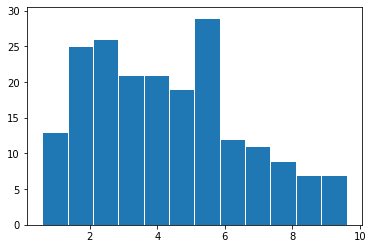

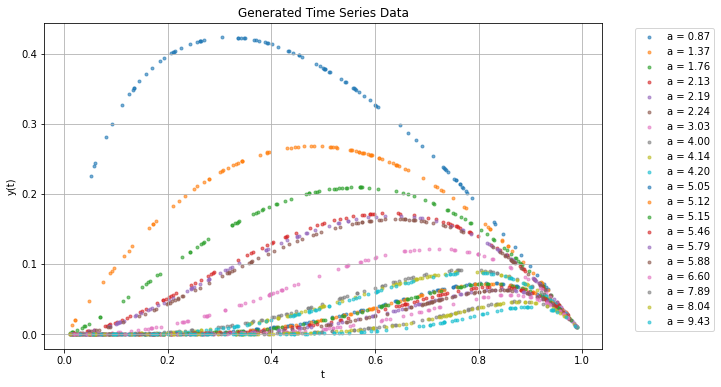

In [5]:
df = generate_dataset(
    n_a_samples=200,
    n_samples_per_a=100,
    a_min=0.5,
    a_max=10,
    seed=SEED,
    beta_alpha=1.2,
    beta_beta=2,
)

display(df)

# Sanity check plot the data:
plt.hist(x=df["a"].unique(), edgecolor='white', bins='rice');  # should follow beta distribution as per data generation function

# Plot some examples of y(t) for different 'a' values
plt.figure(figsize=(10, 6))
for a in sorted(df["a"].unique()[::10]):
    subset = df[df["a"] == a]
    plt.scatter(x=subset["t"], y=subset["y"], label=f"a = {a:.2f}", marker='.', alpha=0.6)

plt.title("Generated Time Series Data")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

## Run experiment on the generated data

### Fit models

In [6]:
# Split data into features and target variable
X = df[["a", "t"]].values  # Features: 'a' and 't'
y = df["y"].values          # Target: 'y'

# Split into training and testing sets with fixed random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Define models with hyperparameters
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Machine": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=20, max_depth=5, random_state=42),
    "LightGBM": LGBMRegressor(
        boosting_type="gbdt",
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.1,
        n_estimators=20,
        reg_lambda=1.0,
        reg_alpha=0.0,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    ),
    "Neural Network": NeuralNetworkRegressor(
        input_dim=2,
        hidden_dim=32,
        learning_rate=0.01, 
        epochs=200,
    ),
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Fit the model on training data
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Evaluate performance using Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{model_name} MSE: {mse:.4f}\n")

Training Linear Regression...
Linear Regression MSE: 0.0044

Training Support Vector Machine...
Support Vector Machine MSE: 0.0033

Training Random Forest...
Random Forest MSE: 0.0003

Training LightGBM...
LightGBM MSE: 0.0002

Training Neural Network...
Epoch [1/200], Loss: 0.0085, Time Elapsed: 00:00
Epoch [10/200], Loss: 0.0005, Time Elapsed: 00:03
Epoch [20/200], Loss: 0.0002, Time Elapsed: 00:05
Epoch [30/200], Loss: 0.0001, Time Elapsed: 00:08
Epoch [40/200], Loss: 0.0001, Time Elapsed: 00:11
Epoch [50/200], Loss: 0.0001, Time Elapsed: 00:14
Epoch [60/200], Loss: 0.0001, Time Elapsed: 00:17
Epoch [70/200], Loss: 0.0001, Time Elapsed: 00:19
Epoch [80/200], Loss: 0.0001, Time Elapsed: 00:22
Epoch [90/200], Loss: 0.0001, Time Elapsed: 00:25
Epoch [100/200], Loss: 0.0001, Time Elapsed: 00:28
Epoch [110/200], Loss: 0.0001, Time Elapsed: 00:31
Epoch [120/200], Loss: 0.0001, Time Elapsed: 00:33
Epoch [130/200], Loss: 0.0001, Time Elapsed: 00:36
Epoch [140/200], Loss: 0.0001, Time Elapse

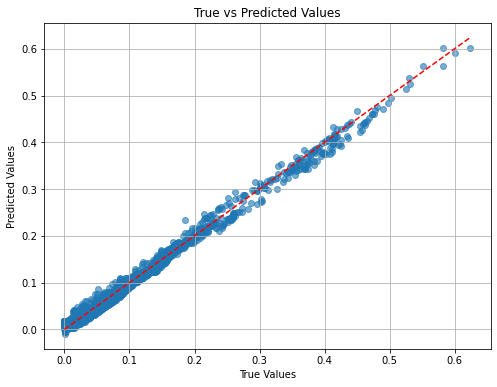

In [7]:
# sanity check plot true vs. predicted values of the last fitted model:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.title("True vs Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

## Run the "trends" experiment for each model (plot trajectories for varying `a`)

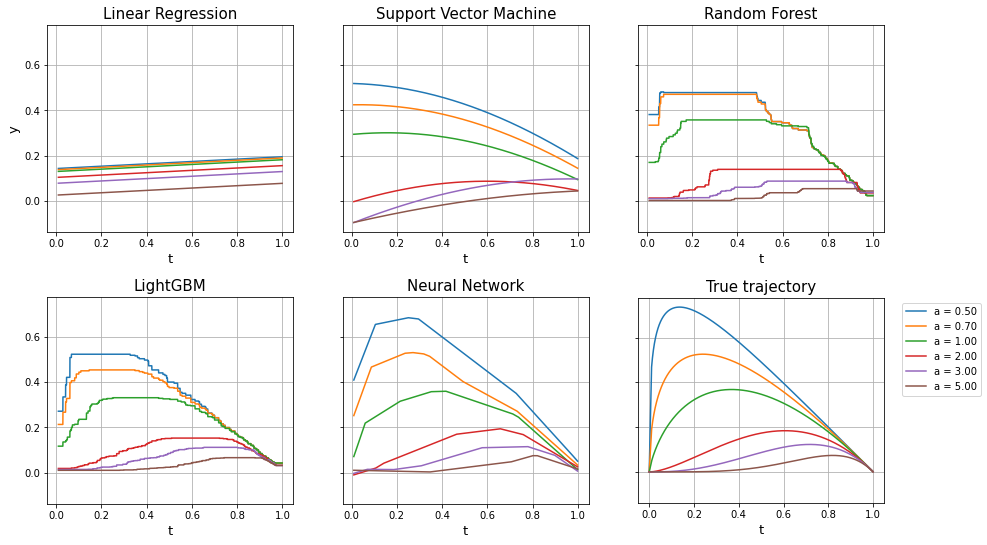

In [8]:
# Define 'a' values and 't' values
a_values = sorted([0.5, 0.7, 1.0, 2, 3, 5])  # Example 'a' values
t_values = np.linspace(start=0.01, stop=0.999, num=10_000)  # Avoid t=0 and t=1 for log stability

# Call the function to plot predictions
plot_model_predictions(
    models,
    a_values,
    t_values,
    n_cols=3,
    subplot_size=(5, 5),
    save_plot=True,
)

## Run the maximiser ("properties") experiment for each model

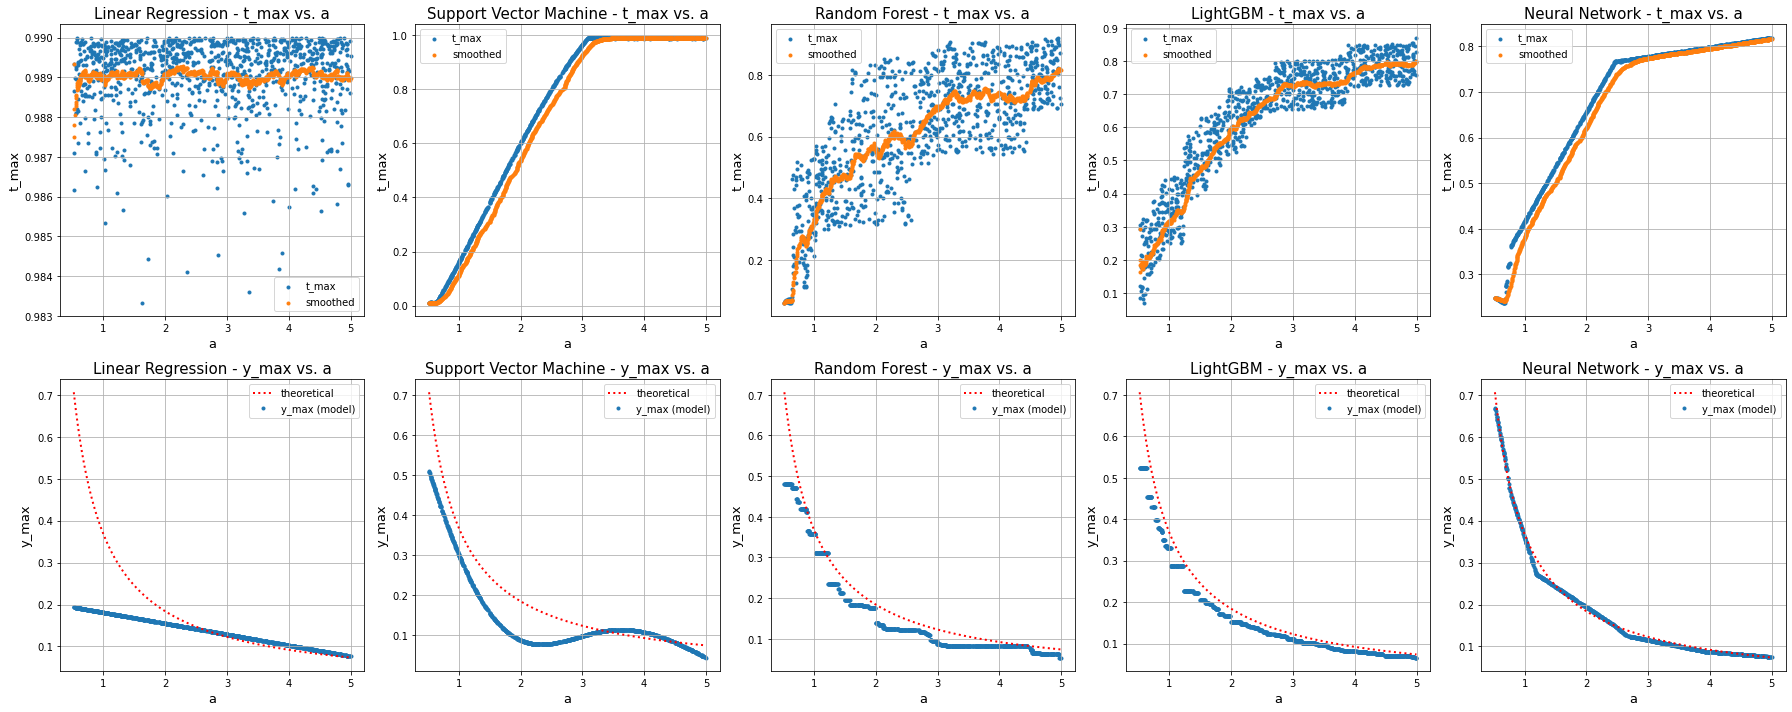

In [9]:
results_df_dict = {}
for model_name, model  in models.items():
    results_df = evaluate_model(
        model=model,
        a_min=0.5,
        a_max=5.0,
        n_a_samples=1000,
        n_t_samples=1000,
        seed=SEED,
    )
    results_df = results_df.sort_values(by="a", ascending=True, ignore_index=True)
    results_df_dict[model_name] = results_df
    
plot_max_results(results_dict=results_df_dict, save_plot=True)